Дз 3. Поиск топиков в текстах, работа с gensim
#### Аня Смирнова БКЛ181 


In [64]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import collections

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

выгружаем датасет.
убираем лишние знаки, стоп-слова, пунктуацию

In [168]:
df_raw = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df_raw.target_names.unique())
df_raw.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",7,rec.autos
1,"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks.\n\nGuy Kuo <guykuo@u.washington.edu>\n",4,comp.sys.mac.hardware
2,"From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected? i'd heard the 185c was supposed to make an\nappearence ""this summer"" but haven't heard anymore on it - and since i\ndon't have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo's just went through recently?\n\n* what's the impression of the display on the 180? i could probably swing\na 180 if i got the 80Mb disk rather than the 120, but i don't really have\na feel for how much ""better"" the display is (yea, it looks great in the\nstore, but is that all ""wow"" or is it really that good?). could i solicit\nsome opinions of people who use the 160 and 180 day-to-day on if its worth\ntaking the disk size and money hit to get the active display? (i realize\nthis is a real subjective question, but i've only played around with the\nmachines in a computer store breifly and figured the opinions of somebody\nwho actually uses the machine daily might prove helpful).\n\n* how well does hellcats perform? ;)\n\nthanks a bunch in advance for any info - if you could email, i'll post a\nsummary (news reading time is at a premium with finals just around the\ncorner... :( )\n--\nTom Willis \ twillis@ecn.purdue.edu \ Purdue Electrical Engineering\n---------------------------------------------------------------------------\n""Convictions are more dangerous enemies of truth than lies."" - F. W.\nNietzsche\n",4,comp.sys.mac.hardware
3,"From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN [version 1.1 PL9]\n\nRobert J.C. Kyanko (rob@rjck.UUCP)

In [172]:
data = df_raw.content.values.tolist()
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [173]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


составляем биграмы и триграмы

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [12]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [174]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['where', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


создаем корпус, каждому слову в корпусе соответствует определенный номер (корпус - лист из листов, которые содержат словари айди_слова - частотность)

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]]


In [17]:
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

In [18]:
dict_df.sort_values('freq', ascending=False).head(10) #тут вывели слова, которые встречаются в корпусе больше всего

,freq
line,11776
would,11604
write,10042
say,7029
know,6550
article,6451
people,6002
go,5846
make,5768
think,5712


дальше работаем с **mallet**

In [19]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2020-10-19 09:33:55--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  13.7MB/s    in 1.1s    

2020-10-19 09:33:56 (13.7 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [20]:
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  in

функция, которая подбирает оптимальное количество групп топиков (грузится ужасно долго,взяла шаг 10, самое оптимальное вышло **32 группы**)

In [27]:
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        mallet_path = '/content/mallet-2.0.8/bin/mallet' 
        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(ldamallet)
        coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        coherence_ldamallet = coherence_model_ldamallet.get_coherence()
        print(coherence_ldamallet)
        coherence_values.append(coherence_ldamallet)

    return model_list, coherence_values

In [28]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=10)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


0.37658984558561215
0.5035707198498258
0.5371216733238552
0.545619030897206


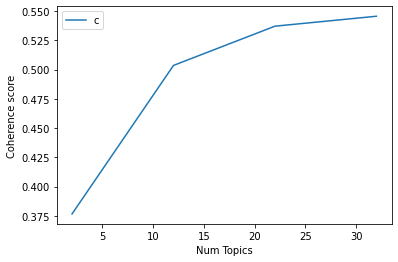

In [29]:
# для наглядности вывела график, показывающий, как изменяется coherence в зависимости от кол-ва топиков
start=2; limit=40; step=10;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
for m, cv in zip(range(start, limit, step), coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3766
Num Topics = 12  has Coherence Value of 0.5036
Num Topics = 22  has Coherence Value of 0.5371
Num Topics = 32  has Coherence Value of 0.5456


определяем главный топик в текстах

In [175]:
mallet_path = '/content/mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=32, id2word=id2word)
tm_results = ldamallet[corpus]
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


In [63]:
# создаем датафрейм для наглядности
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Title'] = df.target_names
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
#добавляем изначальный текст в датафрейм
contents = pd.Series(texts)
corpus_topic_df = pd.concat([corpus_topic_df, contents], axis=1)
corpus_topic_df.columns = ['Title', 'Dominant_Topic', 'Contribution %', 'Topic Terms', 'Text']
corpus_topic_df

,Title,Dominant_Topic,Contribution %,Topic Terms,Text
0,rec.autos,21,19.29,"car, engine, good, drive, speed, mile, buy, model, oil, article, road, owner, tire, driver, change, lock, dealer, high, light, brake","[where, thing, car, nntp_poste, host, park, line, wonder, could, enlighten, car, see, day, door, sport, car, look, late, early, call, bricklin, door, really, small, addition, separate, rest, body, know, tellme, model, name, engine, year, production, car, make, history, info, funky, look, car, mail, thank, bring, neighborhood, lerxst]"
1,comp.sys.mac.hardware,11,11.78,"card, driver, bit, speed, memory, scsi, fast, pc, run, chip, machine, mode, printer, port, bus, slow, performance, board, device, ram","[poll, final, call, summary, final, call, clock, report, keyword, acceleration, line, host, fair, number, brave, soul, upgrade, clock, oscillator, share, experience, poll, send, brief, message, detailing, experience, procedure, top, speed, attain, cpu, rate, speed, add, card, hour, usage, day, functionality, floppy, especially, request, summarize, next, day, add, network, knowledge, base, do, clock, upgrade, answer, poll, thank]"
2,comp.sys.mac.hardware,19,9.46,"drive, system, problem, work, disk, line, computer, tape, pin, apple, machine, boot, internal, add, cable, switch, instal, controller, type, set","[engineering, computer, network, distribution_usa, line, well, folk, finally, give, ghost, weekend, start, life, way, back, be, market, new, machine, bit, sooner, intend, be, look, pick, powerbook, maybe, bunch, question, hopefully, answer, know, dirt, powerbook, introduction, expect, would, hear, suppose, make, appearence, summer, hear, anymore, since, access, macleak, wonder, info, hear, rumor, price, drop, line, one, duos, go, recently, s, impression, display, could, probably, swing, get, disk, rather, really, feel, much, well, display, yea, look, great, store, really, good, could, solicit, opinion, people, day, worth, take, disk, size, money, hit, get, active, display, realize, real, subjective, question, have, play, machine, computer, ...]"
3,comp.graphics,12,7.84,"write, article, line, organization, host, nntp_poste, reply, opinion, news, university, disclaimer, originator, nntp_posting, net, employer, previous, necessarily, mine, dept, joke","[division, line, host, write, write, article, know, chip, far, stuff, go, look, pretty, nice, get, quadrilateral, fill, command, require, point, weitek, address, phone, number, would, information, chip, division, thing, really, scare, person, sense, humor, winter]"
4,sci.space,9,11.95,"window, run, set, application, problem, server, display, call, work, program, font, mouse, client, keyboard, create, error, db_db, widget, resource, character","[question, distribution, article, write, clear, caution, warn, memory, verify, unexpected, error, wonder, expect, error, may, sorry, really, dumb, question, parity_error, memory, previously, know, condition, waivere, error, already, know, would, curious, real, meaning, expect, error, basically, know, bug, warn, system, software, thing, check, right, value, yet, set, launch, suchlike, rather, fix, code, possibly, introduce, new, bug, tell, crew, see, warn, ignore]"
...,...,...,...,...,...
11309,sci.med,22,34.11,"food, doctor, patient, effect, disease, eat, pain, treatment, medical, day, find, study, people, blood, week, article, body, lot, msg, test","[scan, city, reply, line, consultation, cheap, also, well, neurologist, make, differential, diagnosis, migraine, tension, headache, cluster, benign, intracranial, hypertension, chronic, syndrome, appear, normal, scan, neurologist, also, recommend, course, treatment, appropriate, diagnosis, also, many, people, convince, brain, tumor, dn, serious, pathology, may, cheap, come, week, dn, easy, take, time, reassure, patient, personally, think, ever, justify, sigh, may, never, justifiable, sometimes, even, try, show, thoroughness, detailed, history, neurologic, examination, discussion, diagnosis,

In [153]:
main_topics = []
for i in corpus_topic_df['Dominant_Topic']:
    #print(i)
    main_topics.append(i)
len(main_topics)

11314

посчитали в скольких текстах встречаются главные топики

In [56]:
dominant_topic_df = corpus_topic_df.groupby('Dominant Topic').agg(
                                  Doc_Count = ('Dominant Topic', np.size),
                                  Total_Docs_Perc = ('Dominant Topic', np.size)).reset_index()

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus), 2))

dominant_topic_df

,Dominant Topic,Doc_Count,Total_Docs_Perc
0,1,371,3.28
1,2,185,1.64
2,3,46,0.41
3,4,255,2.25
4,5,432,3.82
5,6,236,2.09
6,7,146,1.29
7,8,216,1.91
8,9,559,4.94
9,10,147,1.30


считаем тф_идф, выделяем пять слов с самой большой тфидф в каждом тексте, записываем в таблицу

In [177]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
tf_idf = TfidfVectorizer(use_idf=True)

In [179]:
df_new = pd.DataFrame(columns=['topic', 'keywords', 'text'])
for t in ldamallet.show_topics(formatted=False):
  topic = t[0]
  corpuss = []
  texts_nums = []
  for num, i in enumerate(texts):
    if main_topics[num] == topic:
      corpuss.append(' '.join(i))
      texts_nums.append(num)
  vector = tf_idf.fit_transform(corpuss)
  for i, num in enumerate(texts_nums):
    text_vector = vector[i]
    df_v = pd.DataFrame(text_vector.T.todense(), index=tf_idf.get_feature_names(), columns=["tfidf"]) 
    keywords = list(df_v.sort_values(by=["tfidf"],ascending=False).index[:5])
    df_new = df_new.append({'text':data[num], 'topic':topic, 'keywords': ', '.join(keywords)}, ignore_index=True)

In [180]:
df_new.head()

,topic,keywords,text
0,22,"dalacin, clearasil, son, usual, treatment","Subject: Teenage acne From: (Pat Churchill) Organization: Actrix Networks Lines: 26 My 14-y-o son has the usual teenage spotty chin and greasy nose. I bought him Clearasil face wash and ointment. I think that is probably enough, along with the usual good diet. However, he is on at me to get some product called Dalacin T, which used to be a doctors-prescription only treatment but is not available over the chemists counter. I have asked a couple of pharmacists who say either his acne is not severe enough for Dalacin T, or that Clearasil is OK. I had the odd spots as a teenager, nothing serious. His father was the same, so I dont figure his acne is going to escalate into something disfiguring. But I know kids are senstitive about their appearance. I am wary because a neighbours son had this wierd malady that was eventually put down to an overdose of vitamin A from acne treatment. I want to help - but with appropriate treatment. My son also has some scaliness around the hairline on his scalp. Sort of teenage cradle cap. Any pointers/advice on this? We have tried a couple of anti dandruff shampoos and some of these are inclined to make the condition worse, not better. Shall I bury the kid till hes 21 :) -- ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ The floggings will continue until morale improves Pat Churchill, Wellington New Zealand"
1,22,"buy, health, disease, adequately, money","From: (Ken Mitchum) Subject: Re: Patient-Physician Diplomacy Article-I.D.: pitt.19422 Reply-To: (Ken Mitchum) Organization: Univ. of Pittsburgh Computer Science Lines: 22 In article (Herman Rubin) writes: >In article (Ken Mitchum) writes: > >>Ditto. Disease is a great leveling experience, however. Some people >>are very much afronted to find out that all the money in the world >>does not buy one health. Everyone looks the same when they die. > >If money does not buy one health, why are we talking about paying >for medical expenses for those not currently ""adequately covered""? Herman, I would think you of all people would/could distinguish between ""health"" and ""treatment of disease."" All the prevention medicine people preach this all the time. You cannot buy health. You can buy treatment of disease, assuming you are lucky enough to have a disease which can be treated. A rich person with a terminal disease is a bit out of luck. There is no such thing as ""adequately covered"" and there never will be. And for what its worth, Ill be the first to admit that all my patients die. -km"
2,22,"antihistamine, link, hismanal, vancenase, sue","From: Subject: Re: Hismanal, et. al.--side effects Organization: Wright State University Lines: 22 In article (Steve Dyer) writes: > In article writes: >>Can someone tell me whether or not any of the following medications >>has been linked to rapid/excessive weight gain and/or a distorted >>sense of taste or smell: Hismanal; Azmacort (a topical steroid to >>prevent asthma); Vancenase. > > Hismanal (astemizole) is most definitely linked to weight gain. > It really is peculiar that some antihistamines have this effect, > and even more so an antihistamine like astemizole which purportedly > doesnt cross the blood-brain barrier and so tends not to cause > drowsiness. It also gave me lots of problems with joint and muscle pain. Seemed to trigger arthritis-like problems. Sue > > -- > Steve Dyer > aka {ima,harvard,rayssd,linus,m2c}!spdcc!dyer"
3,22,"weather, warm, cold, hail, randomly","From: (Douglas Fitts) Subject: Re: RA treatment question Organization: University of Washington Lines: 24 NNTP-Posting-Host: carson.u.washington.edu (Julia Eulenberg) writes: >Im assuming that you mean Rheumatoid Arthritis (RA). Ive never heard >of the ""cold treatment"" you mentioned. I cant imagine how it would >work, since most of us who have Rh.Arthr./RA seem to have more problems >in cold weather than in warm weather. Would be interested 

**coherence score**

Благодаря метрикам coherence мы можем разделить условно все топики на плохие и хорошие. Как это происходит:


1.   набор слов t сегментируется на набор пар подмножеств слов S
2.   вероятности слов P вычисляются на основе заданного эталонного корпуса
3.   набор подмножеств слов S и полученные вероятности используются в дальнейшем для получения когерентности C (то есть связи между ними)

У этого метода есть две метрики: внутренняя и внешняя. Они отличаются тем, что внутренняя метрика сравнивает последовательно попарно слова, а внешняя - попарно со всеми словами в тексте. 

По сути этот показатель измеряет топик посредством вычисления степени семантической близости слов с большим весом (то есть большой вероятностью). 

